# ヒューリスティック法
まず、デポから最も近い未訪問の顧客を見つけ、その顧客が現在の車両の容量と時間窓内で訪問できるかどうかを確認します。  
可能であれば、その顧客を訪問し、車両の残容量を更新します。  
次に、最後に訪問した顧客から最も近い未訪問の顧客を探し、同じプロセスを繰り返します。  
車両の容量が足りなくなった場合、または時間窓を超えた場合は、新しい車両をデポから出発させます。  
すべての顧客を訪問するまでこのプロセスを繰り返します。  

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import time
import csv

In [31]:
dfschool = pd.read_csv('evaluation/fukurois_v2.csv',index_col = 0)
# The desired order
desired_order = [28, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]#対象　いちばん初めはデマンド
dfschool = dfschool.reindex(desired_order)
dfschool = dfschool.reset_index(drop=True)##学校数設定しておく
dfschool

,学校名,住所,センター,longitude,latitude,dish,class,dish_container,demand,elevation,start_time,end_time,start,end
0,中部センター,豊沢２２８９−２,中部センター,34.737693,137.964272,0,0,0,0,71.022873,0,720,0.0,12.0
1,袋井東小学校,広岡2317番地の１,中部センター,34.758102,137.945052,318,13,2,2,15.248384,630,690,10.5,11.5
2,袋井西小学校,袋井市川井442番地,中部センター,34.746236,137.916140,543,20,3,3,12.070471,630,690,10.5,11.5
3,袋井南小学校,高尾740番地,中部センター,34.742079,137.931908,641,22,3,3,25.327871,630,690,10.5,11.5
4,袋井北小学校,久能1580番地,中部センター,34.759207,137.914826,"1,079",34,6,6,14.273340,630,690,10.5,11.5
5,高南小学校,上田町306番地の２,中部センター,34.734721,137.934382,441,15,3,3,12.849963,630,690,10.5,11.5
6,浅羽東小学校,浅羽2800番地,中部センター,34.721179,137.927260,387,13,3,2,17.661812,630,690,10.5,11.5
7,袋井中学校,川井701番地,中部センター,34.745832,137.918893,860,30,4,4,11.627437,630,700,10.5,11.7
8,袋井南中学校,愛野3110番地,中部センター,34.742036,137.942423,522,16,3,3,30.801228,630,700,10.5,11.7
9,袋井東幼稚園,国本2288番地,中部センター,34.760808,137.937936,69,3,0,1,14.773001,630,660,10.5,11.0


In [32]:
dfvehicle = pd.read_csv('evaluation/中部給食センター_車両.csv', index_col = 0)
dfvehicle 

,name,container,t,memo
1,1いすずエルフ,6,３ｔ,パワーゲート付
2,2いすずエルフ,6,３ｔ,パワーゲート付
3,3いすずエルフ,6,３ｔ,パワーゲート付
4,4いすずエルフ,6,３ｔ,パワーゲート付
5,5いすずエルフ,4,２ｔ,NaN
6,6いすずエルフ,4,２ｔ,NaN
7,7いすずエルフ,4,２ｔ,NaN
8,8トヨタ,6,３ｔ,NaN
9,9日野デュトロ,6,２ｔ,NaN


In [33]:
#距離
df_distance = pd.read_csv('csv/distance_matrix.csv', header=None)
# Reorder the matrix
distance = df_distance.iloc[desired_order, desired_order].values.tolist()
distance

[[0.0,
  4.188,
  5.846,
  3.952,
  6.655,
  3.566,
  4.975,
  5.677,
  3.359,
  5.669,
  5.713,
  6.382,
  4.794,
  6.993,
  8.114,
  5.636,
  5.111,
  7.795,
  5.634,
  5.598],
 [4.188,
  0.0,
  3.178,
  3.695,
  3.211,
  3.738,
  5.622,
  3.263,
  2.429,
  1.254,
  3.456,
  7.731,
  5.441,
  8.448,
  10.151,
  7.473,
  9.009,
  10.049,
  7.472,
  7.519],
 [5.553,
  3.178,
  0.0,
  2.023,
  2.18,
  2.856,
  4.589,
  0.477,
  3.29,
  2.92,
  0.133,
  2.609,
  4.676,
  5.37,
  9.325,
  5.265,
  8.626,
  9.223,
  5.09,
  5.646],
 [3.952,
  3.694,
  2.022,
  0.0,
  3.124,
  1.782,
  3.78,
  1.853,
  1.688,
  3.298,
  1.889,
  3.429,
  3.599,
  6.064,
  8.309,
  5.338,
  7.167,
  8.207,
  5.163,
  5.677],
 [7.667,
  3.485,
  2.181,
  3.136,
  0.0,
  4.703,
  6.436,
  2.263,
  4.303,
  2.533,
  2.456,
  5.125,
  6.523,
  7.575,
  10.125,
  7.008,
  10.883,
  10.023,
  6.833,
  7.493],
 [3.566,
  3.738,
  2.856,
  1.782,
  4.486,
  0.0,
  2.784,
  2.687,
  1.304,
  3.614,
  2.723,
  3.742,


In [34]:
#移動時間
df_duration = pd.read_csv('csv/duration_matrix.csv', header=None)
# Reorder the matrix
duration = df_duration.iloc[desired_order, desired_order].values.tolist()
duration

[[0.0,
  7.6,
  11.6,
  7.316666666666666,
  15.066666666666666,
  6.483333333333333,
  8.016666666666667,
  11.1,
  5.316666666666666,
  11.3,
  11.05,
  11.366666666666667,
  7.233333333333333,
  10.833333333333334,
  12.283333333333331,
  8.733333333333333,
  9.0,
  11.616666666666667,
  8.15,
  8.366666666666667],
 [7.766666666666667,
  0.0,
  7.15,
  8.283333333333333,
  6.366666666666666,
  7.55,
  10.8,
  7.2,
  4.35,
  3.85,
  7.383333333333334,
  9.95,
  10.016666666666667,
  15.666666666666666,
  18.25,
  14.333333333333334,
  15.933333333333334,
  17.85,
  13.75,
  13.85],
 [11.566666666666666,
  7.366666666666666,
  0.0,
  6.75,
  7.333333333333333,
  8.133333333333333,
  10.033333333333331,
  1.9166666666666667,
  8.5,
  7.7,
  0.5,
  5.333333333333333,
  9.85,
  9.95,
  15.783333333333331,
  10.35,
  17.733333333333334,
  15.4,
  9.633333333333333,
  12.033333333333331],
 [7.333333333333333,
  8.616666666666667,
  6.85,
  0.0,
  10.25,
  5.3,
  8.7,
  6.35,
  4.2833333333

In [35]:
# サービス時間
service_time = 5  # 分

# Customer count ('0' is depot) 
customer_count = len(dfschool)
# The number of vehicle
vehicle_count = len(dfvehicle)
# The capacity of vehicle
vehicle_capacity = list(dfvehicle['container'])

In [41]:
def nearest_neighbour_algorithm(distance, duration, service_time, vehicle_capacity, demand, start_time, end_time):
    """
    Nearest Neighbour Algorithm for VRP
    """
    # Initialize
    unvisited_customers = list(range(1, customer_count))
    routes = []

    vindex = 0
    while unvisited_customers:
        # Start a new route with a vehicle
        current_position = 0
        current_route = [current_position]
        current_vehicle_capacity = vehicle_capacity[vindex]  # Assuming all vehicles have same capacity for now
        current_time = 0

        # Visit customers as long as the vehicle has capacity and is within time window
        while unvisited_customers:
            nearest_distance = float('inf')
            nearest_customer = None

            for customer in unvisited_customers:
                if distance[current_position][customer] < nearest_distance:
                    if current_time + duration[current_position][customer] + service_time <= end_time[customer] and \
                       current_vehicle_capacity >= demand[customer]:
                        nearest_distance = distance[current_position][customer]
                        nearest_customer = customer

            # If we found a customer to visit
            if nearest_customer is not None:
                current_route.append(nearest_customer)
                current_vehicle_capacity -= demand[nearest_customer]
                current_time += duration[current_position][nearest_customer] + service_time
                current_position = nearest_customer
                unvisited_customers.remove(nearest_customer)
            else:
                # If no more customers can be visited by this vehicle, end the route
                current_route.append(0)  # Return to depot
                routes.append(current_route)
                break

        # If we've visited all customers, return to depot and finish
        if not unvisited_customers:
            current_route.append(0)
            routes.append(current_route)

        vindex+=1

    return routes

# Extracting demand, start_time, and end_time from the school dataframe
demand = dfschool["demand"].tolist()
start_time = dfschool["start_time"].tolist()
end_time = dfschool["end_time"].tolist()

# Calculate routes using Nearest Neighbour Algorithm
routes = nearest_neighbour_algorithm(distance, duration, service_time, vehicle_capacity, demand, start_time, end_time)
routes


[[0, 8, 5, 0],
 [0, 3, 10, 11, 15, 0],
 [0, 1, 9, 2, 0],
 [0, 12, 6, 18, 13, 0],
 [0, 16, 19, 0],
 [0, 7, 0],
 [0, 17, 14, 0],
 [0, 4, 0]]

In [37]:
def calculate_route_info(routes, distance):
    """
    Calculate route information such as number of vehicles used, total distance, and distance per vehicle.
    """
    # Number of vehicles used
    num_vehicles = len(routes)
    
    # Vehicles used
    vehicles_used = [i+1 for i in range(num_vehicles)]
    
    # Total number of customers visited
    total_customers_visited = sum([len(route)-2 for route in routes])  # Subtracting 2 for depot at start and end
    
    # Total distance traveled by all vehicles
    total_distance = sum([sum([distance[route[i]][route[i+1]] for i in range(len(route)-1)]) for route in routes])
    
    # Distance traveled by each vehicle
    distance_per_vehicle = [sum([distance[route[i]][route[i+1]] for i in range(len(route)-1)]) for route in routes]
    
    return num_vehicles, vehicles_used, total_customers_visited, total_distance, distance_per_vehicle

# Calculating route information
num_vehicles, vehicles_used, total_customers_visited, total_distance, distance_per_vehicle = calculate_route_info(routes, distance)
num_vehicles, vehicles_used, total_customers_visited, total_distance, distance_per_vehicle


(8,
 [1, 2, 3, 4, 5, 6, 7, 8],
 19,
 112.64600000000002,
 [8.229,
  17.927,
  13.969000000000001,
  15.689,
  15.003,
  11.061,
  16.445999999999998,
  14.322])

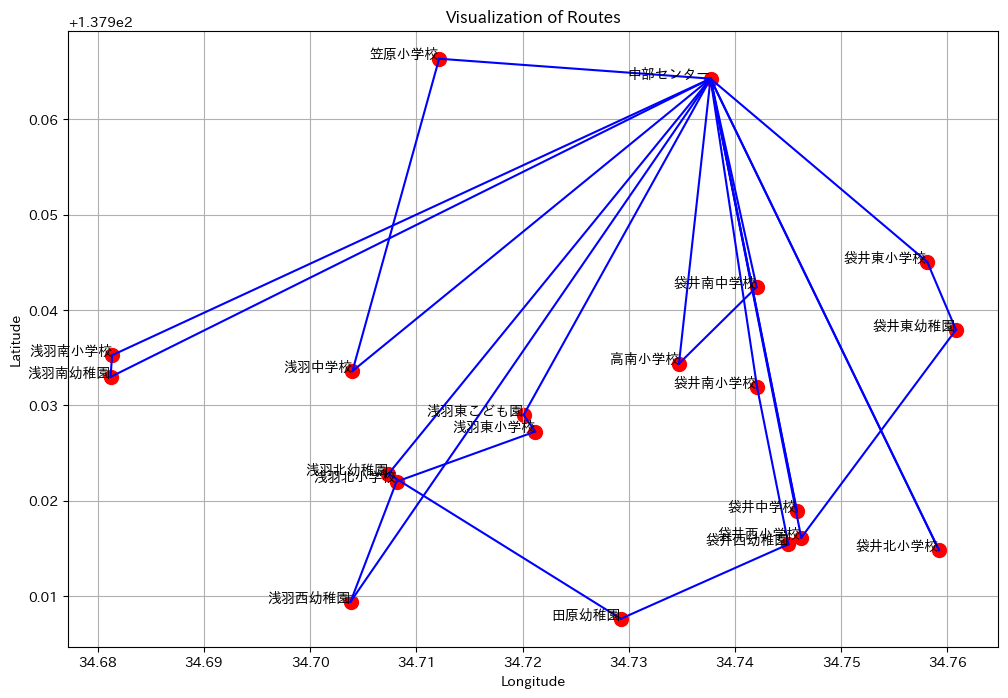

In [38]:
def plot_routes(routes, latitudes, longitudes, school_names):
    """
    Plot the routes on a 2D plane using latitude and longitude.
    """
    plt.figure(figsize=(12, 8))
    
    # Plot all points
    plt.scatter(longitudes, latitudes, s=100, c='red', marker='o')
    
    # Annotate points
    for i, name in enumerate(school_names):
        plt.annotate(name, (longitudes[i], latitudes[i]), fontsize=10, ha='right')
    
    # Plot routes
    for route in routes:
        for i in range(len(route)-1):
            plt.plot([longitudes[route[i]], longitudes[route[i+1]]], 
                     [latitudes[route[i]], latitudes[route[i+1]]], c='blue')
    
    plt.title("Visualization of Routes")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

# Extracting latitudes, longitudes, and school names from the dataframe
latitudes = dfschool["latitude"].tolist()
longitudes = dfschool["longitude"].tolist()
school_names = dfschool["学校名"].tolist()

# Plotting the routes
plot_routes(routes, latitudes, longitudes, school_names)

[0, 8, 5, 0]
[0, 3, 10, 11, 15, 0]
[0, 1, 9, 2, 0]
[0, 12, 6, 18, 13, 0]
[0, 16, 19, 0]
[0, 7, 0]
[0, 17, 14, 0]
[0, 4, 0]


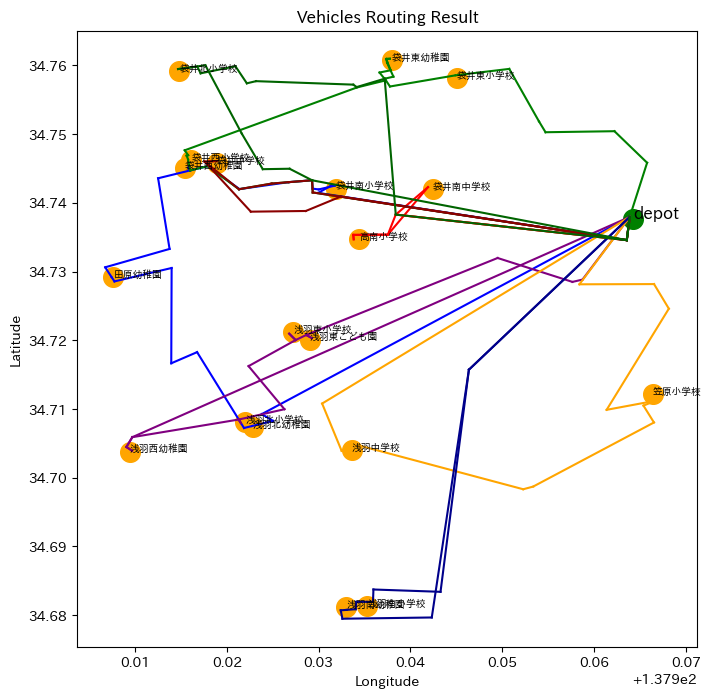

In [39]:
def plotgraph(dfschool, name, vehicle_count, customer_count, routes):
    # Visualization: plotting with matplotlib
    plt.figure(figsize=(8, 8))
    for i in range(customer_count):
        if i == 0:
            plt.scatter(dfschool['latitude'][i], dfschool['longitude'][i], c='green', s=200)
            plt.text(dfschool['latitude'][i], dfschool['longitude'][i], "depot", fontsize=12)
        else:
            plt.scatter(dfschool['latitude'][i], dfschool['longitude'][i], c='orange', s=200)
            plt.text(dfschool['latitude'][i], dfschool['longitude'][i], str(dfschool.学校名[i]), fontsize=7)

    list_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'darkgreen', 'cadetblue', 'pink', 'gray', 'black', 'lightgray']
    index = 0
    for ind, route in enumerate(routes):
        print(route)
        for rind in range(len(route) - 1):
            i = route[rind]
            j = route[rind + 1]
            if i != j:
                with open('root/latlngs_{}-{}.csv'.format(dfschool['学校名'][i], dfschool['学校名'][j])) as f:
                    reader = csv.reader(f)
                    indexx = 0
                    for row in reader:
                        if indexx != 0:
                            plt.plot([float(row[1]), float(indexx[1])], [float(row[0]), float(indexx[0])], c=list_colors[ind])  # 縦軸と横軸を逆転
                        indexx = row
            
            plt.savefig('evaluation_result/{}_{}_{}_index{}.png'.format(name, vehicle_count, customer_count, index))
            index += 1
            #time.sleep(1)
    """
    for k in range(vehicle_count):
        for i in range(customer_count):
            for j in range(customer_count):
                if i != j and pulp.value(x[i][j][k]) == 1:
                    #plt.plot([dfschool.longitude[i], dfschool.longitude[j]], [dfschool.latitude[i], dfschool.latitude[j]], c="black")
                    plt.plot([dfschool['longitude'][i], dfschool['longitude'][j]], [dfschool['latitude'][i], dfschool['latitude'][j]], c="black")
                    plt.savefig('evaluation_result/{}_{}_{}.png'.format(name, vehicle_count, customer_count))
    """
    plt.savefig('evaluation_result/{}_{}_{}.png'.format(name, vehicle_count, customer_count))
    plt.title("Vehicles Routing Result")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

name = 'ヒューリスティック'
plotgraph(dfschool, name, vehicle_count, customer_count, routes)

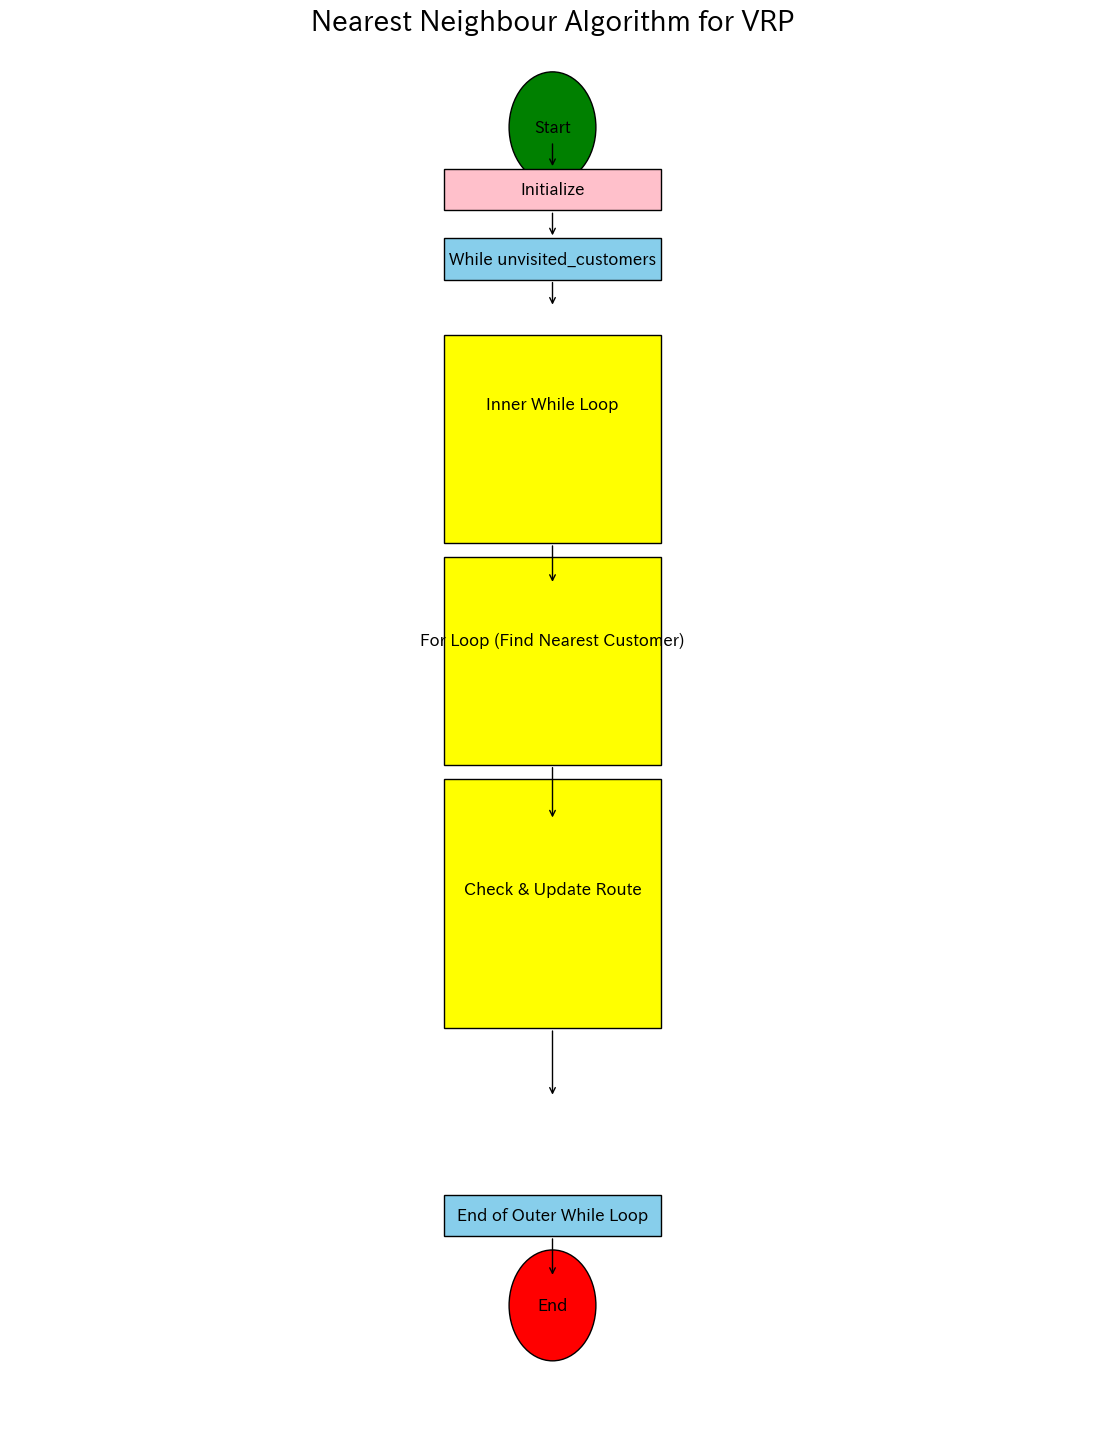

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(14, 18))

# Title
ax.text(0.5, 1.02, 'Nearest Neighbour Algorithm for VRP', transform=ax.transAxes, size=20, ha="center")

# Draw shapes
start = mpatches.Circle((0.5, 0.95), 0.04, color="g", ec="black")
init = mpatches.Rectangle((0.4, 0.89), 0.2, 0.03, color="pink", ec="black")
while_loop = mpatches.Rectangle((0.4, 0.84), 0.2, 0.03, color="skyblue", ec="black")
inner_while = mpatches.Rectangle((0.4, 0.65), 0.2, 0.15, color="yellow", ec="black")
inner_for = mpatches.Rectangle((0.4, 0.49), 0.2, 0.15, color="yellow", ec="black")
check = mpatches.Rectangle((0.4, 0.3), 0.2, 0.18, color="yellow", ec="black")
end_while = mpatches.Rectangle((0.4, 0.15), 0.2, 0.03, color="skyblue", ec="black")
end = mpatches.Circle((0.5, 0.1), 0.04, color="r", ec="black")

# Add patches
ax.add_patch(start)
ax.add_patch(init)
ax.add_patch(while_loop)
ax.add_patch(inner_while)
ax.add_patch(inner_for)
ax.add_patch(check)
ax.add_patch(end_while)
ax.add_patch(end)

# Add texts
ax.text(0.5, 0.95, 'Start', ha="center", va="center", size=12)
ax.text(0.5, 0.905, 'Initialize', ha="center", va="center", size=12)
ax.text(0.5, 0.855, 'While unvisited_customers', ha="center", va="center", size=12)
ax.text(0.5, 0.75, 'Inner While Loop', ha="center", va="center", size=12)
ax.text(0.5, 0.58, 'For Loop (Find Nearest Customer)', ha="center", va="center", size=12)
ax.text(0.5, 0.4, 'Check & Update Route', ha="center", va="center", size=12)
ax.text(0.5, 0.165, 'End of Outer While Loop', ha="center", va="center", size=12)
ax.text(0.5, 0.1, 'End', ha="center", va="center", size=12)

# Draw arrows
ax.annotate("", xy=(0.5, 0.92), xytext=(0.5, 0.94), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.5, 0.87), xytext=(0.5, 0.89), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.5, 0.82), xytext=(0.5, 0.84), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.5, 0.62), xytext=(0.5, 0.65), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.5, 0.45), xytext=(0.5, 0.49), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.5, 0.25), xytext=(0.5, 0.3), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.5, 0.12), xytext=(0.5, 0.15), arrowprops=dict(arrowstyle="->"))

# Hide axis
ax.axis("off")

plt.show()
